In [2]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [68]:
def calibration():
    objpoints = []
    imgpoints = []
    
    images = glob.glob('./camera_cal/calibration*.jpg')
    
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    for fname in images:    
        print('Reading image {}'.format(fname))
        img = mpimg.imread(fname)        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)        
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        else:
            print('No grid found for {}'.format(fname))
        
    
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

ret, mtx, dist, rvecs, tvecs = calibration()

Reading image ./camera_cal/calibration1.jpg
No grid found for ./camera_cal/calibration1.jpg
Reading image ./camera_cal/calibration10.jpg
Reading image ./camera_cal/calibration11.jpg
Reading image ./camera_cal/calibration12.jpg
Reading image ./camera_cal/calibration13.jpg
Reading image ./camera_cal/calibration14.jpg
Reading image ./camera_cal/calibration15.jpg
Reading image ./camera_cal/calibration16.jpg
Reading image ./camera_cal/calibration17.jpg
Reading image ./camera_cal/calibration18.jpg
Reading image ./camera_cal/calibration19.jpg
Reading image ./camera_cal/calibration2.jpg
Reading image ./camera_cal/calibration20.jpg
Reading image ./camera_cal/calibration3.jpg
Reading image ./camera_cal/calibration4.jpg
No grid found for ./camera_cal/calibration4.jpg
Reading image ./camera_cal/calibration5.jpg
No grid found for ./camera_cal/calibration5.jpg
Reading image ./camera_cal/calibration6.jpg
Reading image ./camera_cal/calibration7.jpg
Reading image ./camera_cal/calibration8.jpg
Reading i

In [76]:
img = mpimg.imread('./camera_cal/calibration1.jpg')
final = cv2.undistort(img, mtx, dist, None, mtx)

In [77]:
# Generate warp matrix

src_x_bottom = 250
src_x_top = 550
src_y_bottom = 685
src_y_top = 480
src_points = np.float32([
    [src_x_bottom, src_y_bottom],
    [src_x_top, src_y_top],
    [img_size[0]-src_x_top, src_y_top],
    [img_size[0]-src_x_bottom, src_y_bottom]
])

dst_points = np.float32([
    [src_x_bottom, img_size[1]],
    [src_x_bottom, 0],
    [img_size[0]-src_x_bottom, 0],
    [img_size[0]-src_x_bottom, img_size[1]]
])

M = cv2.getPerspectiveTransform(src_points, dst_points)

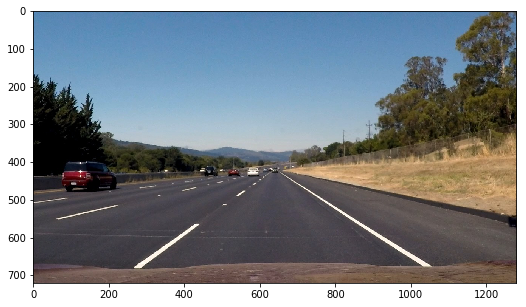

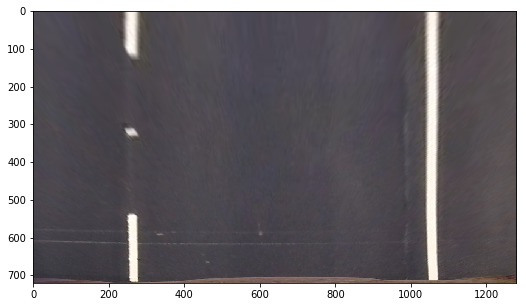

In [114]:
def warp_to_birdview(img):
    img_size = (ex_img1.shape[1], ex_img1.shape[0])    

    warped = cv2.warpPerspective(ex_img1, M, img_size, flags=cv2.INTER_LINEAR)
    return warped
    
ex_img1 = mpimg.imread('./test_images/straight_lines2.jpg')
# ex_img1 = cv2.undistort(ex_img1, mtx, dist, None, mtx)
plt.imshow(ex_img1)
plt.show()

warped = warp_to_birdview(ex_img1)
plt.imshow(warped)
plt.show()

In [115]:
gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
# plt.imshow(gray, cmap='gray')
# plt.show()

In [116]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return scaled_sobel

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    arctan_thresh = [0.7, 1.3]
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= arctan_thresh[0]) & (absgraddir <= arctan_thresh[1])] = 1
    return binary_output

In [117]:
# sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
# abs_sobelx = np.absolute(sobelx)
# scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
# abs_sobely = np.absolute(sobely)
# scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))

# plt.imshow(scaled_sobelx, cmap='gray')
# plt.show()
# plt.imshow(scaled_sobely, cmap='gray')
# plt.show()

In [118]:
# thresh_min = 20
# thresh_max = 100
# sxbinary = np.zeros_like(scaled_sobelx)
# sxbinary[(scaled_sobelx >= thresh_min) & (scaled_sobelx <= thresh_max)] = 1
# plt.imshow(sxbinary, cmap='gray')

In [119]:
mag_thresh = [40, 150]
gradmag = np.sqrt(sobelx**2 + sobely**2)
scale_factor = np.max(gradmag)/255
gradmag = (gradmag/scale_factor).astype(np.uint8) 
binary_output = np.zeros_like(gradmag)
binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
plt.imshow(binary_output, cmap='gray')

NameError: name 'sobelx' is not defined

In [120]:
arctan_thresh = [0.0, 0.2]
absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
binary_output =  np.zeros_like(absgraddir)
binary_output[(absgraddir >= arctan_thresh[0]) & (absgraddir <= arctan_thresh[1])] = 1

plt.imshow(binary_output, cmap='gray')
plt.show()

NameError: name 'sobely' is not defined

In [121]:
def print_img(img):
    if len(img.shape) > 2:        
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    plt.show()

In [197]:
def process_each_image(img):
    # Undistort based on camera calibration
    img = cv2.undistort(img, mtx, dist, None, mtx)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply sobel
    sobel_kernel_size = 15
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel_size)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel_size)
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    mag_thresh = [50, 180]
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    mag_binary = binary_output
    
    arctan_thresh = [0.7, 1.3]
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= arctan_thresh[0]) & (absgraddir <= arctan_thresh[1])] = 1
    dir_binary = binary_output
    
    combined = np.zeros_like(dir_binary)
    combined[((sobelx == 1) & (sobely == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    img = combined

    img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return img
    
ex_img1 = mpimg.imread('./test_images/test3.jpg')
img = process_each_image(ex_img1)

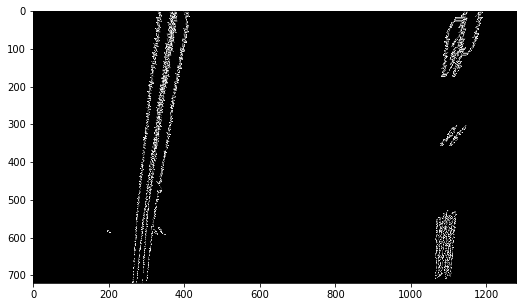

In [128]:
fig_size = [20,5]
plt.rcParams["figure.figsize"] = fig_size
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
# histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
out_img = np.dstack((img, img, img))*255
plt.imshow(out_img)
plt.show()

# plt.plot(histogram)
# print_img(out_img)


midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint


# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(img.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = img.shape[0] - (window+1)*window_height
    win_y_high = img.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
# plt.imshow(out_img)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)

In [15]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [81]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((img, img, img))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (43245,9)

(array([  0,   0,   0, ..., 665, 665, 665]), array([238, 239, 240, ..., 594, 602, 603]))
1903.20401917 2560.68765935
578.995474565 m 1026.84131345 m
(1, 1, 1440, 2)


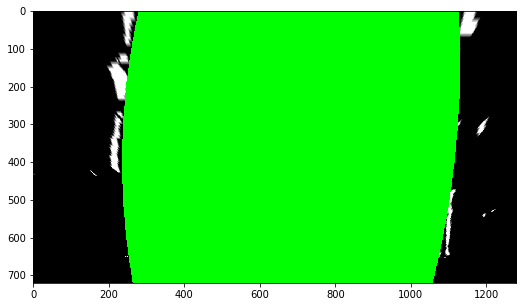

In [302]:
def calculate_polynomials(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    print(nonzero)
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     out_img = out_img * 255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]    
    plt.imshow(out_img)

#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

    # Generate some fake data to represent lane-line pixels
#     ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([src_x_top + (y**2)*left_fit[0] + np.random.randint(-50, high=51) 
                                  for y in ploty])
    rightx = np.array([(img_size[0]-src_x_top) + (y**2)*right_fit[0] + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)

#     # Fit a second order polynomial to pixel positions in each fake lane line
# #     left_fit = np.polyfit(ploty, leftx, 2)
# #     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# #     right_fit = np.polyfit(ploty, rightx, 2)
# #     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     # Plot up the fake data
#     mark_size = 3
#     print(leftx.shape)
#     print(ploty.shape)
#     plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
#     plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
# #     plt.xlim(0, 1280)
# #     plt.ylim(0, 720)
#     plt.plot(left_fitx, ploty, color='green', linewidth=3)
#     plt.plot(right_fitx, ploty, color='green', linewidth=3)
#     plt.gca().invert_yaxis() # to visualize as we do the images

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

  

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    return np.int_([pts])
#     plt.show()
    # Draw the lane onto the warped blank image
#     binary_warped = cv2.fillPoly(binary_warped, np.int_([pts]), (0,255, 0))
    
#     plt.imshow(img)
#     plt.show()

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
#     _, Minv = cv2.invert(M)
#     newwarp = cv2.warpPerspective(img, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
#     plt.imshow(newwarp, cmap='gray')
#     result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
#     plt.imshow(result)
#     return left_fitx, right_fitx
    
    
original = mpimg.imread('./test_images/test5.jpg')

gray = process_each_image(original)
pts = calculate_polynomials(gray)
gray = (gray * 255).astype(np.uint8)
gray = np.dstack((gray, gray, gray))    

print(pts.shape)
binary_warped = cv2.fillPoly(binary_warped, pts, (0,255, 0))

_, Minv = cv2.invert(M)
newwarp = cv2.warpPerspective(binary_warped, Minv, (gray.shape[1], gray.shape[0])) 


plt.imshow(newwarp)
plt.show()

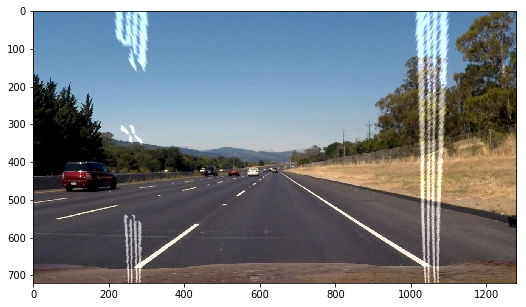

In [79]:

def process(img):
    
    # Process the individual image
    processed = process_each_image(img)
    
    # Transform it back to 3 dimension (rgb) and 128 mean uint8 array
    processed = (processed * 255).astype(np.uint8)
    processed = np.dstack((processed, processed, processed))    
    processed = cv2.addWeighted(img, 1.0, processed, 0.5, 0)

    return processed

img = mpimg.imread('./test_images/straight_lines2.jpg')

img = process(img)
plt.imshow(img)
plt.show()


In [18]:
# def video_process(img):
#     img = process_each_image(img)
#     img = 
#     return img

# ex_img1 = mpimg.imread('./test_images/test3.jpg')
# video_process(ex_img1)

In [58]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_video = 'output.mp4'
# clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("shorter.mp4")
output_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:14,  3.21it/s]

  4%|▍         | 2/48 [00:00<00:13,  3.33it/s]

  6%|▋         | 3/48 [00:00<00:13,  3.40it/s]

  8%|▊         | 4/48 [00:01<00:12,  3.42it/s]

 10%|█         | 5/48 [00:01<00:15,  2.79it/s]

 12%|█▎        | 6/48 [00:02<00:15,  2.69it/s]

 15%|█▍        | 7/48 [00:02<00:14,  2.79it/s]

 17%|█▋        | 8/48 [00:02<00:13,  2.89it/s]

 19%|█▉        | 9/48 [00:03<00:13,  2.93it/s]

 21%|██        | 10/48 [00:03<00:13,  2.79it/s]

 23%|██▎       | 11/48 [00:03<00:12,  2.89it/s]

 25%|██▌       | 12/48 [00:04<00:11,  3.05it/s]

 27%|██▋       | 13/48 [00:04<00:11,  3.11it/s]

 29%|██▉       | 14/48 [00:04<00:10,  3.26it/s]

 31%|███▏      | 15/48 [00:04<00:09,  3.38it/s]

 33%|███▎      | 16/48 [00:05<00:09,  3.46it/s]

 35%|███▌      | 17/48 [00:05<00:08,  3.49it/s]

 38%|███▊      | 18/48 [00:05<00:08,  3.54it/s]

 40%|███▉      | 19/48 [00:05<00:08,  3.60it/s]

 42%|████▏     | 20/48 [00:06<00:07,

[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 10.8 s, sys: 3.94 s, total: 14.8 s
Wall time: 16.6 s
